## Advanced aperture photometry
This notebook provides code to perform aperture photometry on a sequence of images where the target star is not shifting by more than ~50 or 100 pixels. It allows you to repeat measurements without going in by hand and redoing everything.

This notebook is basically the aperture photometry notebook (in this same directory), except for this notebook allows you to select (via coordinates) exactly which stars you are going to use as comparison stars.

Lab 3 detailed how to do simple aperture photometry. I highly recommend going through Lab 3 before this so that you understand what is going on here.

We are going to use Group 3's observations of SW Lac for this exercise.

### Identifying the star of interest.
First we need to identify which star is SW Lac. Begin by opening up the source in simbad. Look at the "aladin lite" view of the source. Try to identify features like triangles and visual binaries (stars that appear to be close together) and try and pinpoint which star is SW Lac. *Usually*, the star of interest will be near the center of the image.

![](ap_photometry_resources/SW_Lac_simbad.png)

<IPython.core.display.Javascript object>


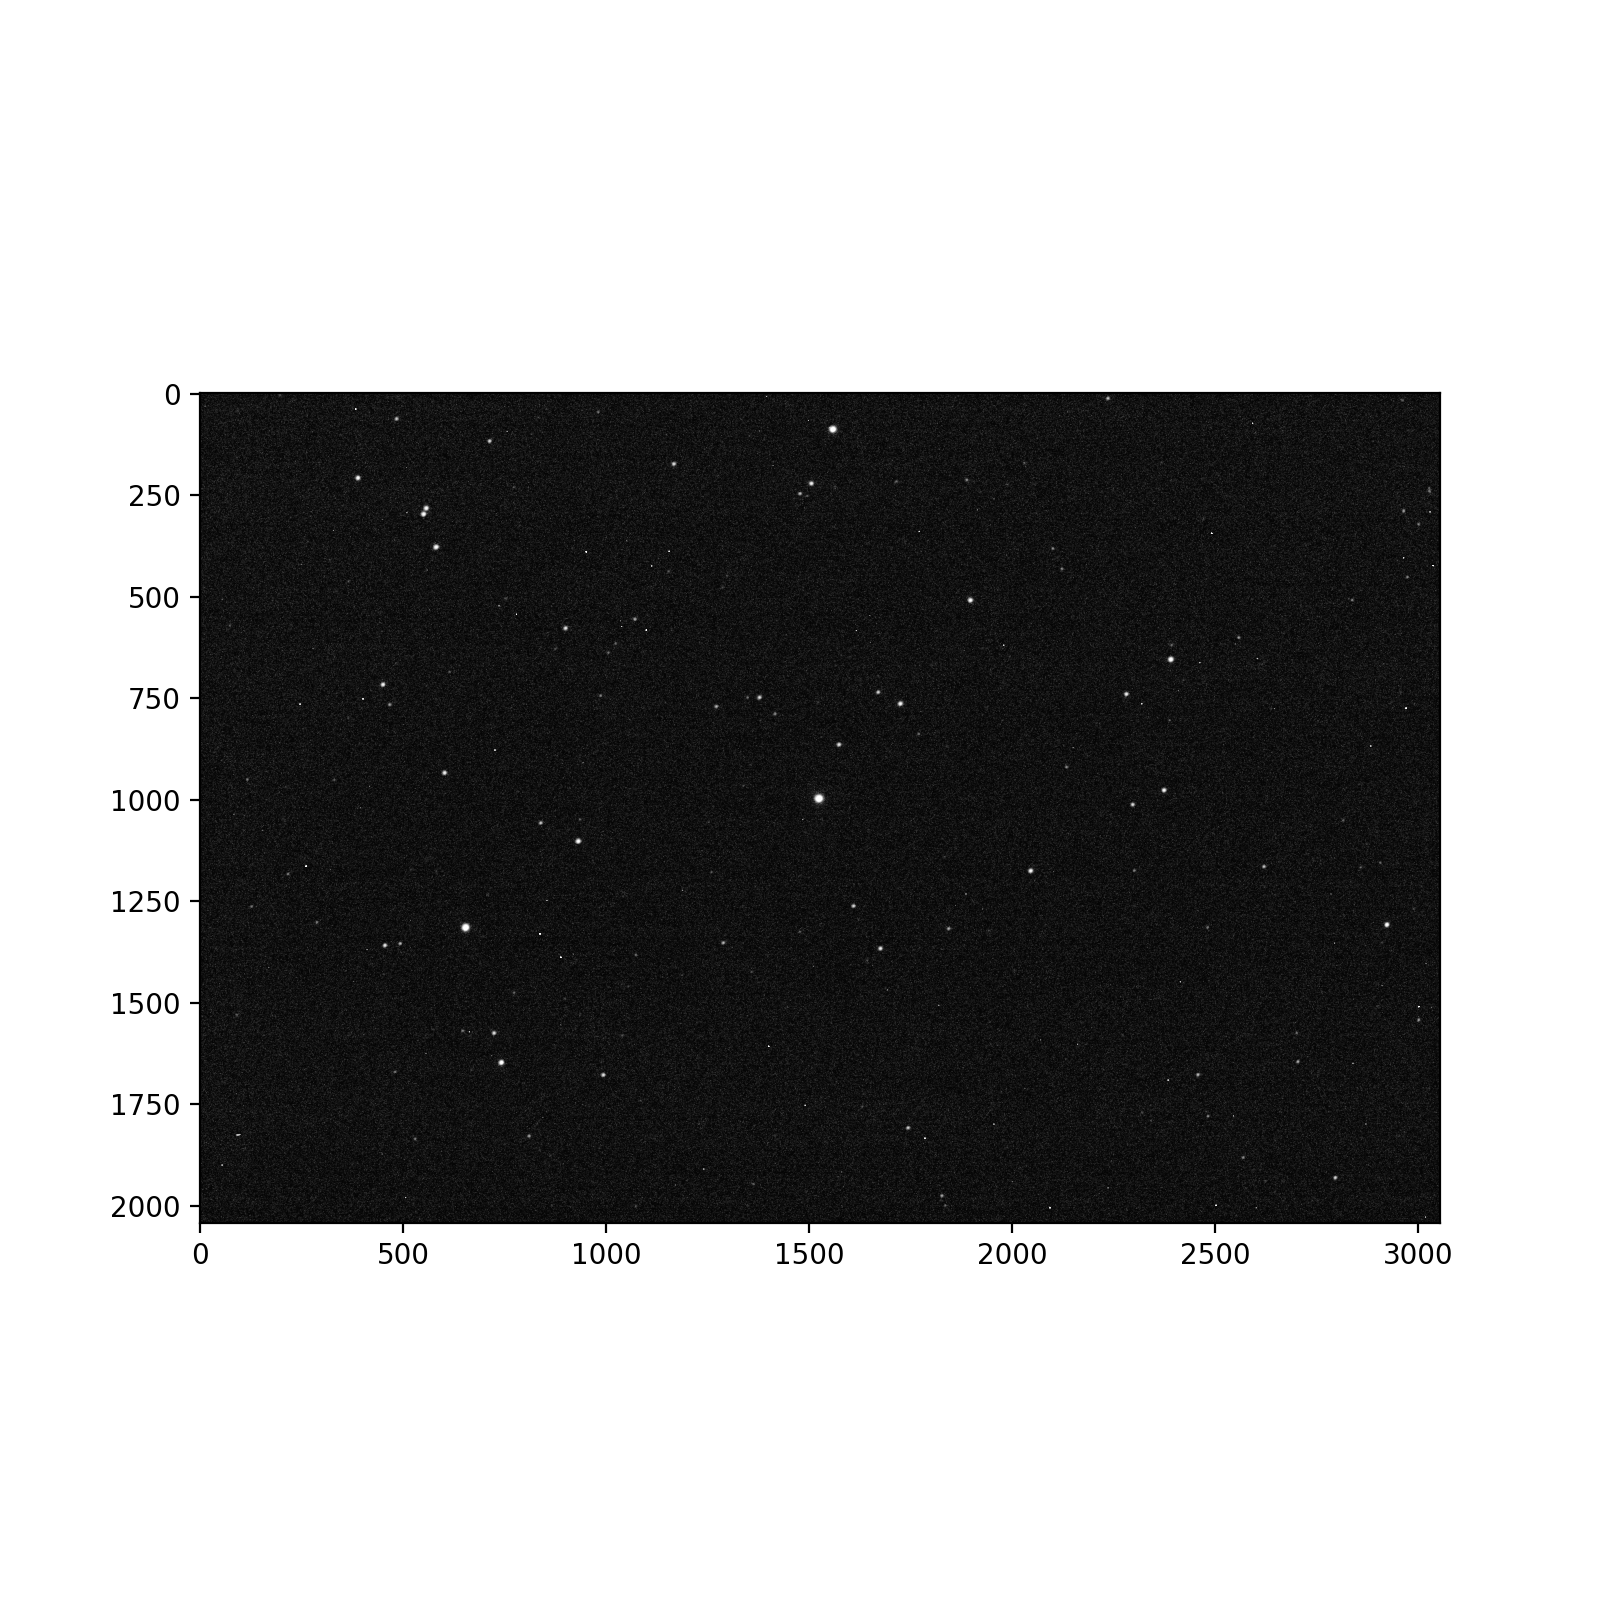

In [1]:

from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib notebook
%matplotlib notebook


hdulist = fits.open('/Users/ria/Desktop/SRA/lco_data_jul15/ogg0m404-kb82-20210714-0110-e91.fits.fz')
im = hdulist['SCI'].data

plt.figure(figsize=(8,8))
display_image = np.copy(im)
min_clip = 10
display_image[display_image<min_clip] = min_clip + 1 # will remove the 'static' of white dots
plt.imshow(np.rot90(display_image, k=0), norm=LogNorm(vmin=min_clip, vmax=1000), cmap='Greys_r')
#plt.xlim((900, 2000)) # zoom in.
#plt.ylim((3000, 1300)) # zoom in.

Its plainly clear that the bright star in the top left of the image above is SW Lac. Now we are going to use a python package called photutils to find all the stars in our image.

In [2]:
from photutils import DAOStarFinder


uncertainty_im = hdulist['ERR'].data  # this is the uncertainty image.

minimum_pixel_size_of_stars = 5  # only finds stars with a pixel width exceeding 5 pixels
minimum_signal_to_noise = 5  # only finds stars with a minimum signal to noise (per pixel) of 5.

signal_to_noise_image = im/uncertainty_im

daofind = DAOStarFinder(fwhm=minimum_pixel_size_of_stars, threshold=minimum_signal_to_noise, exclude_border=True)
all_sources = daofind(signal_to_noise_image)  # it is important that we feed the image/uncertainty_image here so that our signal-to-noise cutoff works.

<IPython.core.display.Javascript object>


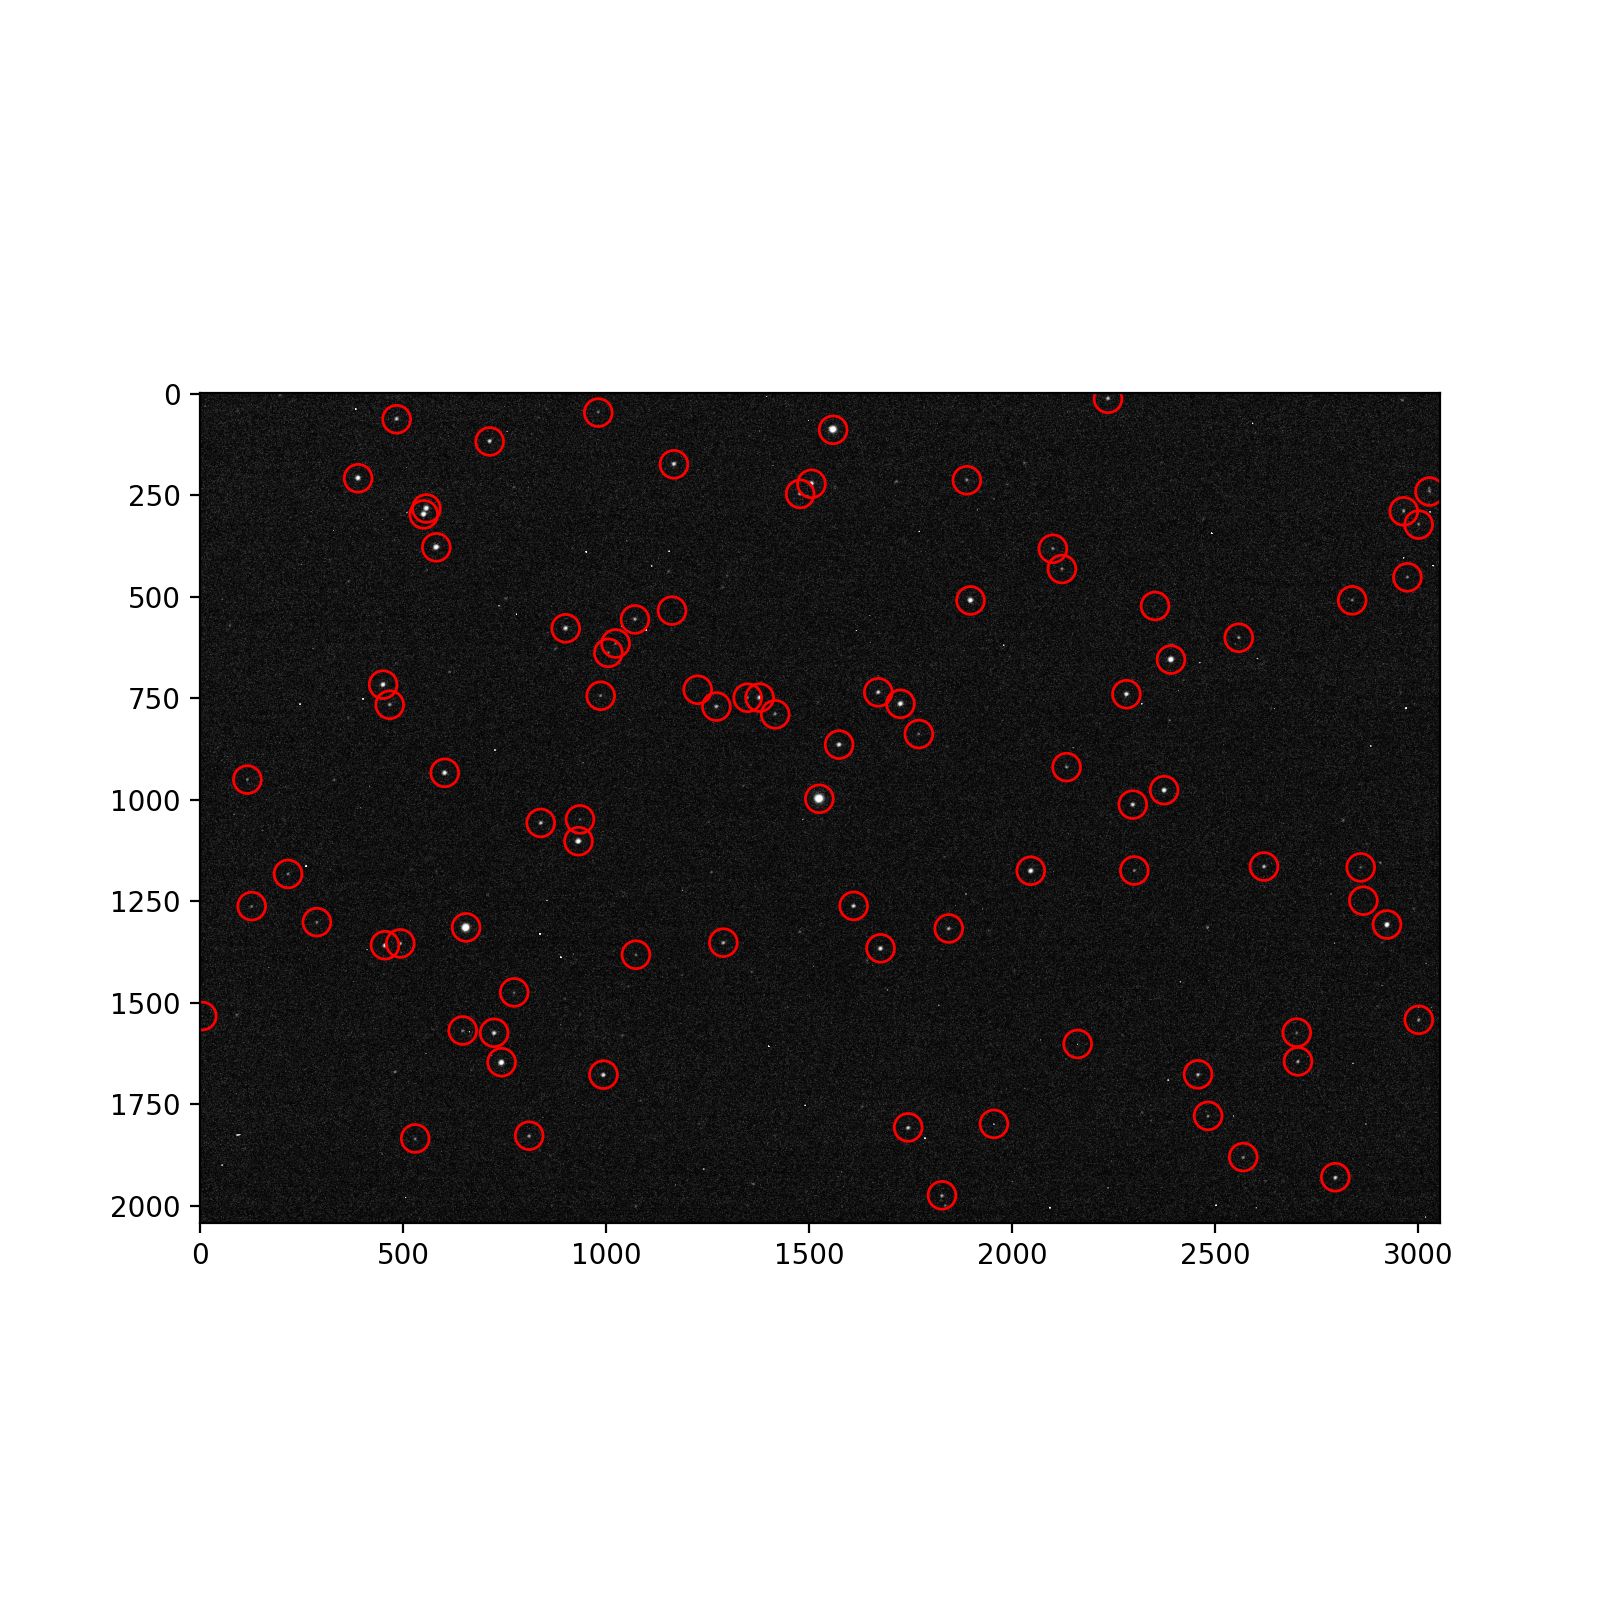

In [3]:
plt.figure(figsize=(8,8))
display_image = np.copy(im)
min_clip = 10
display_image[display_image<min_clip] = min_clip + 1 # will remove the 'static' of white dots
plt.imshow(display_image, norm=LogNorm(vmin=min_clip, vmax=700), cmap='Greys_r')
plt.scatter(all_sources['xcentroid'], all_sources['ycentroid'], marker='o', facecolor='none', s=100, edgecolor='r')

Note that we have left the image above non-rotated. SW Lac is now the bright star in the bottom left.

Now we want to mock up some code to find SW Lac in any image that we feed, where SW Lac is at least in the same region of the sky. 
In pseudo code we are going to:
1. Select all stars in the y,x region you want
2. Perform aperture photometry on those stars.
3. SW Lac is going to always be the brightest star in that region, so take that table of flux values and get me the row with the largest flux. That must be SW Lac.
Done!

There are going to be functions here that you have never seen before. Like np.logical_and. Please look up the documentation for them! E.g., https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html

In [4]:
x_limits = (0, 3000)
y_limits = (0, 3000)
sources_that_have_correct_x_coordinate = np.logical_and(all_sources['xcentroid'] > min(x_limits), all_sources['xcentroid'] < max(x_limits))
sources_that_have_correct_y_coordinate = np.logical_and(all_sources['ycentroid'] > min(y_limits), all_sources['ycentroid'] < max(y_limits))

sources_that_are_in_our_box = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)

sources = all_sources[sources_that_are_in_our_box]

In [5]:
# these are all the sources found. THere should be an equal number of red circles in the above image as there
# are rows in this table
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2235.8080812142334 ...  2.850326047425713  -1.1372363539675079
  2  980.4316455175378 ...  1.182938967365846 -0.18240584546670446
  3  483.7730891643043 ... 2.8709451220828264  -1.1450622276672575
  4 1558.8413066500682 ... 14.406038683733994   -2.896361441572602
  5  712.8719793320872 ... 3.1227425943226526  -1.2363404677220386
  6 1166.6922606550856 ...  4.032093962266814   -1.513826610440462
  7 388.86151837249554 ... 5.7129518893921505   -1.892151416855605
  8 1888.2276492906692 ... 1.5844046464912622  -0.4996652684106629
  9 1505.4457957700968 ...  5.218996186376878  -1.7939674487701498
 11  1477.609538610163 ...   2.72041379509503  -1.0865874211683897
...                ... ...                ...                  ...
 77  742.2913742643848 ...   8.93245251353598     -2.3774267902399
 78  2457.524045660619 ... 2.8835674413167762  -1.149825283028

OK so everything looks good! Ignore the flux and mag columns. We are going to compute those ourselves.

In [6]:
from photutils import CircularAperture

positions = [(s['xcentroid'], s['ycentroid']) for s in sources] # make a list of (x, y) tuple positions
# yes this time you should really use x,y  , not y,x!!! 
print(len(positions), 'sources')

84 sources


In [7]:
from photutils.aperture import aperture_photometry

aperture = CircularAperture(positions, r=20.)
phot_table = aperture_photometry(im, aperture, error=uncertainty_im)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id      xcenter            ycenter       aperture_sum  aperture_sum_err
           pix                pix                                       
--- ------------------ ------------------ ------------ -----------------
  1 2235.8080812142334 12.642719252757791     9065.107  526.662571731326
  2  980.4316455175378  46.58282759885985    4544.4221  555.050646032309
  3  483.7730891643043  63.00900618065461    12072.143  572.197185899958
  4 1558.8413066500682   89.1111476810355    241143.85 739.2115954708903
  5  712.8719793320872 117.77971210454432     12722.04 568.9683777120722
  6 1166.6922606550856  173.9955420434599    15540.649 566.5284304370768
  7 388.86151837249554 208.39843833733283    34778.532 586.8548494492863
  8 1888.2276492906692 213.30178721788042     5821.083 552.1034204750551
  9 1505.4457957700968 222.08098012016725    24983.748 574.6678656371782
 10  1477.609538610163 246.90392556657503    10929.995 553.4122051530732
...                ...                ...          

In [8]:
phot_table.sort('aperture_sum', reverse=True)
print(phot_table)
print('note that the square of the aperture_sum_err column is within about a factor of two of aperture_sum itself.')

 id      xcenter            ycenter       aperture_sum  aperture_sum_err 
           pix                pix                                        
--- ------------------ ------------------ ------------ ------------------
 45 1524.8030806093784  997.7973447331252    610991.17  949.6339950423105
 60  654.8445073119617 1314.5918233469602    368796.98  808.8362969942283
  4 1558.8413066500682   89.1111476810355    241143.85  739.2115954708903
 13  550.5981266338472 297.39220968088733    77985.246  629.0774266223306
 11  557.1615150046647 282.80342299641416    77593.971  628.0772001195498
 27 2390.9222192479297  654.9297993919729    67606.081  599.8987900911212
 74  742.2913742643848 1646.6163361818726     64593.35  590.9320290890122
 14  581.4859958127273   378.559391260747    46492.361  596.6422992130281
 49  931.6439296607135 1102.2700996665253    45322.001  569.9415812397231
 59  2922.900245081828 1307.4923188066737     43066.58  580.3567588197859
...                ...                

#### Look at the top most column. The aperture_sum is 3 million! Compared to the next brightest star has 2 million (this is the comparison star). So the 3 million star must be the brightest. The brightest star in the image is SW Lac, and so we have found a reliable way to find SW Lac. Just take the star (in our little sub region) that is the brightest.


Ok, now we could compute the flux of our star relative to the other brightest stars that we saw in the image. This will give us a roughly constant set point. Normally, you would want to do this "comparison" with a set of standard stars in the field (instead of just random nearby stars that I see).

Anchoring the flux to a set of "comparison stars" (the same within each image!) will cause our fluxes/exposure_time to (hopefully) be calibrated. Meaning any variation that we see is just due to variations in SW Lac.

For SW Lac, there is a nearby star, in the region we selected, that is a good star to use as a comparison star. We will compute the brightness of SW Lac relative to this star (comparing the brightness, hence the name "comparison star"). This star is BD+37 4715 and is the second brightest star in that region. It is near x,y coordinate 2480, 340. 

In [9]:
from astropy.table import vstack

def find_brightest_near(phot_table, x, y, r):
    sources_that_have_correct_x_coordinate = np.isclose(phot_table['xcenter'].value, x, atol=r)
    sources_that_have_correct_y_coordinate = np.isclose(phot_table['ycenter'].value, y, atol=r)

    sources_that_are_nearby_xy = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)
    phot_table_nearby = phot_table[sources_that_are_nearby_xy]
    phot_table_nearby.sort('aperture_sum', reverse=True)
    if len(phot_table_nearby) == 0:
        return None
    return phot_table_nearby[0]

comparison_stars = {'name': ['TYC-2141-1508-1', 'TYC-2141-916-1'], 
                    'x': [1650, 630], 'y': [1420, 1380], 'r': [100, 100]}

number_of_comparison_stars = len(comparison_stars['x'])
comparison_star_phot_table = []
for i in range(number_of_comparison_stars):
    x, y, r = comparison_stars['x'][i], comparison_stars['y'][i], comparison_stars['r'][i]
    comparison_star_information = find_brightest_near(phot_table, x, y, r)
    comparison_star_phot_table.append(comparison_star_information)
    
comparison_star_phot_table = vstack(comparison_star_phot_table)

HD_coords = {'x': 1500, 'y': 1060, 'r': 200}
HD_information = find_brightest_near(phot_table, HD_coords['x'], HD_coords['y'], HD_coords['r'])

HD_flux = HD_information['aperture_sum']
HD_flux_error = HD_information['aperture_sum_err']

comparison_star_flux = np.average(comparison_star_phot_table['aperture_sum'])
comparison_star_flux_error = np.sqrt(np.sum(comparison_star_phot_table['aperture_sum_err']**2)/number_of_comparison_stars**2)

Now, as a final step, lets convert to magnitudes. For this, remember we just take $-2.5\cdot \log_{10}(\frac{\rm flux- flux\_sky}{\rm exposure time})$

flux_sky is so small that we will ignore it for now. Although technically this will improve your result slightly.



In [10]:
exposure_time = hdulist['SCI'].header['EXPTIME'] # we will need this later

HD_magnitude = -2.5*np.log10(HD_flux/exposure_time)
comparison_star_magnitude = -2.5*np.log10(comparison_star_flux/exposure_time)
print(HD_magnitude)
print('the relative mag, i.e. HD magnitude minus our comparison star is:')
print(HD_magnitude - comparison_star_magnitude)

-12.087229435859221
the relative mag, i.e. HD magnitude minus our comparison star is:
-1.246098079767922


Now for the error in the magnitude, you will remember this from Lab 3 :)

In [11]:
def inst_mag(flux, flux_error, exposure_time):
    ft = flux/exposure_time
    magnitude = -2.5*np.log10(flux/exposure_time)
    var_ft = flux_error**2/exposure_time**2
    var_inst_mag = var_ft * (2.5/ft/np.log(10))**2
    return magnitude, np.sqrt(var_inst_mag)

HD_magnitude, HD_magnitude_error = inst_mag(HD_flux, HD_flux_error, exposure_time)
comparison_star_magnitude, comparison_star_magnitude_error = inst_mag(comparison_star_flux, comparison_star_flux_error,
                                                                      exposure_time)

rel_mag = HD_magnitude - comparison_star_magnitude
rel_mag_error = np.sqrt(HD_magnitude_error**2 + comparison_star_magnitude_error**2)

print(f'The magnitude of HD relative to the average of the comparison stars is {round(rel_mag, 3)} +- {round(rel_mag_error, 4)}')

The magnitude of HD relative to the average of the comparison stars is -1.246 +- 0.0032


### Last part: Putting it all together in functions, then running it on multiple images.

I am going to copy and paste all the above code into functions, then re-run the analysis using those functions, on that first image. I want to verify that I get the same answer. This is testing my code to make sure that I have not made any errors.

Then I am going to run my aperture photometry code on two of the images in the sequence.

In [12]:
from astropy.time import Time
from astropy.table import Table
from glob import glob

def load_image(filepath):
    hdulist = fits.open(filepath)
    mid_image_time = Time(hdulist['sci'].header['date-obs'])
    return hdulist['SCI'].data.astype(float), hdulist['ERR'].data.astype(float), hdulist['SCI'].header['EXPTIME'], mid_image_time

def find_stars(im, uncertainty_im, minimum_pixel_size_of_stars=5, minimum_signal_to_noise=5):
    signal_to_noise_image = im/uncertainty_im

    daofind = DAOStarFinder(fwhm=minimum_pixel_size_of_stars, threshold=minimum_signal_to_noise, exclude_border=True)
    all_sources = daofind(signal_to_noise_image)  # it is important that we feed the image/uncertainty_image here so that our signal-to-noise cutoff works.
    return all_sources

def restrict_sources_to_within_box(all_sources, x_limits=(0, 3000), y_limits=(0, 3000)):
    sources_that_have_correct_x_coordinate = np.logical_and(all_sources['xcentroid'] > min(x_limits), all_sources['xcentroid'] < max(x_limits))
    sources_that_have_correct_y_coordinate = np.logical_and(all_sources['ycentroid'] > min(y_limits), all_sources['ycentroid'] < max(y_limits))

    sources_that_are_in_our_box = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)

    sources = all_sources[sources_that_are_in_our_box]
    return sources

def ap_photometry(sources, im, uncertainty_im, aperture_pixel_radius=30.0):
    positions = [(s['xcentroid'], s['ycentroid']) for s in sources]
    aperture = CircularAperture(positions, r=aperture_pixel_radius)
    phot_table = aperture_photometry(im, aperture, error=uncertainty_im)
    phot_table.sort('aperture_sum', reverse=True)
    return phot_table


def get_relative_magnitude(phot_table, star_coords, comparison_star_coords):
    number_of_comparison_stars = len(comparison_star_coords['x'])
    comparison_star_phot_table = []
    for i in range(number_of_comparison_stars):
        x, y, r = comparison_star_coords['x'][i], comparison_star_coords['y'][i], comparison_star_coords['r'][i]
        comparison_star_information = find_brightest_near(phot_table, x, y, r)
        comparison_star_phot_table.append(comparison_star_information)

    if None in comparison_star_phot_table:
        print('ERROR! at least one of the comparison stars was not found in the image. Check that you are not restricting to a sub region of the image that does not contain the stars.')
        return np.nan, np.nan # short circuit 
    comparison_star_phot_table = vstack(comparison_star_phot_table)


    star_information = find_brightest_near(phot_table, star_coords['x'], star_coords['y'], star_coords['r'])

    star_flux = star_information['aperture_sum']
    star_flux_error = star_information['aperture_sum_err']

    comparison_star_flux = np.average(comparison_star_phot_table['aperture_sum'])
    comparison_star_flux_error = np.sqrt(np.sum(comparison_star_phot_table['aperture_sum_err']**2)/number_of_comparison_stars**2)

    star_magnitude, star_magnitude_error = inst_mag(star_flux, star_flux_error, exposure_time)
    comparison_star_magnitude, comparison_star_magnitude_error = inst_mag(comparison_star_flux, comparison_star_flux_error,
                                                                          exposure_time)

    rel_mag = star_magnitude - comparison_star_magnitude
    rel_mag_error = np.sqrt(star_magnitude_error**2 + comparison_star_magnitude_error**2)
    
    # relative magnitude and relative_magnitude error
    return rel_mag, rel_mag_error




def inst_mag(flux, flux_error, exposure_time):
    ft = flux/exposure_time
    magnitude = -2.5*np.log10(flux/exposure_time)
    var_ft = flux_error**2/exposure_time**2
    var_inst_mag = var_ft * (2.5/ft/np.log(10))**2
    return magnitude, np.sqrt(var_inst_mag)

# Putting all the above functions together:
def process_image(filepath_to_e91_file, star_coords, comparison_star_coords, x_limits, y_limits):
    im, uncertainty_im, exposure_time, observation_time = load_image(filepath_to_e91_file)
    all_sources = find_stars(im, uncertainty_im)
    sources = restrict_sources_to_within_box(all_sources, x_limits=x_limits, y_limits=y_limits)
    phot_table = ap_photometry(sources, im, uncertainty_im, aperture_pixel_radius=20.0)
    mag, mag_error = get_relative_magnitude(phot_table, star_coords, comparison_star_coords)

    return mag, mag_error, observation_time

In [13]:
# grabbing all the e91 images:
all_images = glob('/Users/ria/Desktop/SRA/lco_data_jul15/*e91*')

star_coords = {'x': 1500, 'y':   1060, 'r': 200} # approximate location of HD 189733
comparison_stars = {'name': ['TYC-2141-1508-1', 'TYC-2141-916-1'], 
                    'x': [1670, 650], 'y': [1360, 1312], 'r': [100, 100]}
# approximate locations of the comparison stars. If more then one star then
# give the x, y coords in order. so {'x': [xcoord of star 1, xcoord of star 2], 'y': [ycoord of star 1, ycoord of star 2]}

# sub region of the image that you want to select. Note that this can just be the whole image...
x_limits = (0, 3000)
y_limits = (0, 3000)
# processing all the images
output = {'mag': [], 'mag_error': [], 'time': []}
for fpath in all_images:
    mag, mag_error, observation_time = process_image(fpath, star_coords, 
                                                     comparison_stars, x_limits=x_limits, 
                                                     y_limits=y_limits)
    output['mag'].append(mag)
    output['mag_error'].append(mag_error)
    output['time'].append(observation_time)



In [14]:
results = Table(output)
print(results)

        mag               mag_error                 time         
------------------- --------------------- -----------------------
-1.2358429195950613  0.003215651433244703 2021-07-15T11:15:36.795
-1.2452791952428885  0.003324383764705573 2021-07-15T12:50:02.401
-1.2105182894470925 0.0032584008545906012 2021-07-15T11:51:27.700
-1.2397537117808977 0.0032707238200001877 2021-07-15T12:43:03.370
-1.2358046339924424  0.003195641385478188 2021-07-15T11:08:45.424
-1.2151109823695396 0.0032722890340782696 2021-07-15T12:05:46.089
-1.2249656371558384 0.0032359737235656974 2021-07-15T11:24:58.866
-1.2465041135175365 0.0032092771090200907 2021-07-15T10:57:24.640
 -1.217618128820547 0.0032888999245775383 2021-07-15T12:24:27.401
-1.2513461168419031  0.003212776701980198 2021-07-15T10:59:41.064
                ...                   ...                     ...
 -1.227147367532071  0.003241162982611276 2021-07-15T11:31:23.013
-1.2441804371641592 0.0032128420064647715 2021-07-15T10:58:31.748
-1.2195807

<IPython.core.display.Javascript object>


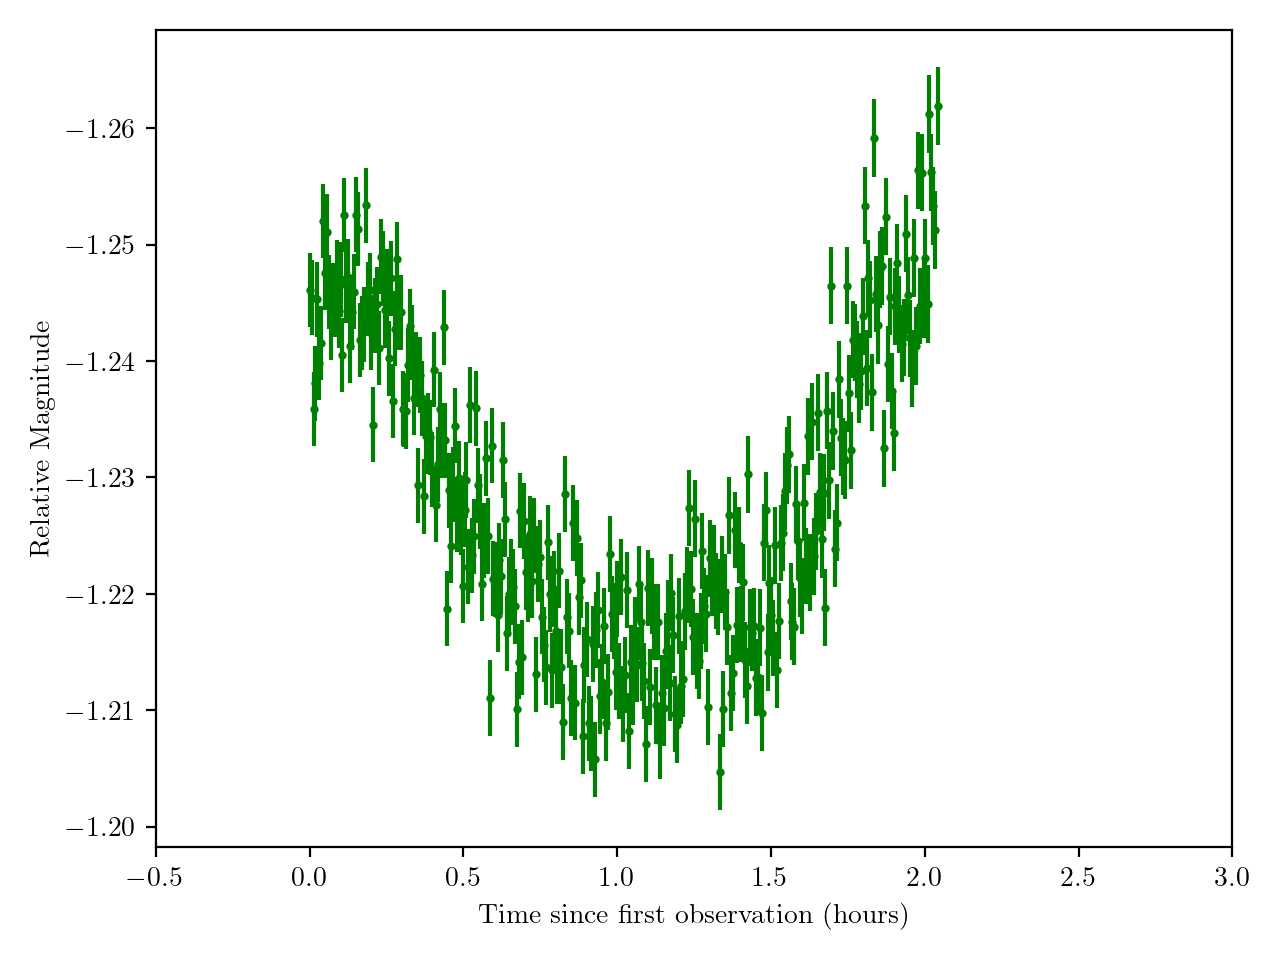

In [15]:
# plotting all the results
import matplotlib
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting


plt.figure()
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.errorbar((results['time'].jd - np.min(results['time'].jd))*24, results['mag'], 
             yerr=results['mag_error'], ls='none', marker='o', markersize=2, color='g')

plt.xlabel('Time since first observation (hours)')
plt.ylabel('Relative Magnitude')

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.xlim(-0.5, 3)

plt.tight_layout()
plt.show()

plt.savefig('finallight_curve.png')


## Converting to real apparent magnitudes, instead of instrumental magnitudes. Only if you want to. IT will just shift the above graph up in the vertical axis.

Ok, we now have $m_{HD} - m_{\rm comparison}$ . I.e., the magnitude difference between HD 189733 and the average of the comparison stars. I chose 2 of those stars from that paper, Ria, as my comparison stars. 

You would need to look up the magnitudes of all the comparison stars in the set, convert those magnitudes to "fluxes" (by doing $10^{0.4 * {\rm magnitude})}$, take the average of the fluxes (for those two stars), then do the average of those fluxes. You would then compute $m_{\rm comparison average} = \log10 (\rm{average \, of \, fluxes}) $ . Then you can add $m_{\rm comparison average}$ to your relative light curve above! Remember that $m_{\rm comparison average}$ will be a single value (an offset for all data points)

In [16]:
# For your group to do! 

Voila! We now have two sets of magnitudes (and fluxes). 

If this were a standard star, we would want these two mags be roughly equal within the errors. By that I mean that the difference in their two magnitude values is less than mag_err. Ideally, those two datapoints should be within the scatter of one another. This means that we have done things correctly (if this was a standard star).

But SW Lac is a variable star, and the comparison star I chose is not a perfect standard star

And these magnitude differences are many times the formal error. This could be due to variability in SW Lac, or it could be due to the fact that I anchored relative to other stars that could be varying themselves (i.e., it could be due to my "data analysis pipeline" being incorrect!).

Canis Li already found the first bug in here (a data pipeline bug), that is in an earlier version of this notebook.

Hint: Look up a light curve of SW Lac. How much (in magnitude) should it be changing over a period of 0.3 hours?

### Disclaimer: This code is not bullet proof. It may require some tweaking for your star/stars. But it is a starting point!!